This notebook is meant for testing multiple machine learning models in the Datahacks 2022 Intermediate Track.

In [1]:
import pandas as pd
import os
import seaborn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack, csr_matrix

In [6]:
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [8]:
stop = stopwords.words('english')

In [41]:
sharktank = pd.read_csv(os.path.join('data', 'intermediate_trainset.csv')).drop(columns=['Deal_Shark'])
sharktank['Pitched_Business_Identifier'] = (
    sharktank.Pitched_Business_Identifier
        .str.lower()
        .str.replace(r"['-.\"]", '', regex=True)
        .str.replace(r'&', 'and', regex=True)
)

sharktank['Pitched_Business_Desc'] = (
    sharktank['Pitched_Business_Desc']
        .str.lower()
        .str.replace(r"['-.\"]", '', regex=True)
        .str.replace(r'&', 'and', regex=True)
        .str.replace(r'\s+a\s+', ' ', regex=True)
        .str.replace(r'\s+an\s+', ' ', regex=True)
        .str.replace(r'^a\s', '', regex=True)
        .str.replace(r'^an\s', '', regex=True)
)

#sharktank['Pitched_Business_Desc'] = (
#    sharktank.Pitched_Business_Desc
#        .apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#)

In [42]:
sharktank

,Season_Epi_code,Pitched_Business_Identifier,Pitched_Business_Desc,Deal_Status
0,826,laid brand,haircare products made with pheromones laid b...,0
1,826,wine and design,painting classes with wine served wine and de...,1
2,824,peoples design,mixing bowl with builtin scoop peoples design...,1
3,824,rumi spice,saffron imported from afghanistan rumi spice ...,1
4,824,wallet buckle,belt buckle that holds credit cards the walle...,1
...,...,...,...,...
525,102,sticky note holder,postit note arm for laptops postit note arm fo...,0
526,101,college foxes packing boxes,packing and organizing service based on alread...,0
527,101,ionic ear,implantable bluetooth device requiring surgery...,0
528,101,mr tods pie factory,pie company,1


In [43]:
sharktank['detailedness'] = (
    sharktank.Pitched_Business_Desc.apply(lambda x: len(x.split())) *
    sharktank.Pitched_Business_Identifier.apply(lambda x: len(x.split()))
)

In [44]:
y_labels = sharktank.Deal_Status
x = sharktank.drop(columns=['Deal_Status'])
x

,Season_Epi_code,Pitched_Business_Identifier,Pitched_Business_Desc,detailedness
0,826,laid brand,haircare products made with pheromones laid b...,64
1,826,wine and design,painting classes with wine served wine and de...,111
2,824,peoples design,mixing bowl with builtin scoop peoples design...,78
3,824,rumi spice,saffron imported from afghanistan rumi spice ...,70
4,824,wallet buckle,belt buckle that holds credit cards the walle...,64
...,...,...,...,...
525,102,sticky note holder,postit note arm for laptops postit note arm fo...,30
526,101,college foxes packing boxes,packing and organizing service based on alread...,136
527,101,ionic ear,implantable bluetooth device requiring surgery...,42
528,101,mr tods pie factory,pie company,8


In [45]:
# Pipeline for transforming features
def feature_transform(business_id_trans, business_desc_trans, features):
    # Transform the features respectively
    id_vector = business_id_trans.transform(features['Pitched_Business_Identifier'])
    desc_vector = business_desc_trans.transform(features['Pitched_Business_Desc'])
    #print(type(id_vector))
    #print(desc_vector)
    final_vector = hstack([id_vector, desc_vector, csr_matrix(features.detailedness).transpose()])
    return final_vector

# General column transformer for model selection
id_pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tf-idf', TfidfTransformer())
])

desc_pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tf-idf', TfidfTransformer())
])

x_train, x_test, y_train, y_test = train_test_split(x, y_labels, test_size=.2, shuffle=True)
id_pipe.fit_transform(x_train.Pitched_Business_Identifier)
desc_pipe.fit_transform(x_train.Pitched_Business_Desc)

x_train_features = feature_transform(id_pipe, desc_pipe, x_train)
x_train_features

<424x4196 sparse matrix of type '<class 'numpy.float64'>'
	with 10045 stored elements in COOrdinate format>

In [46]:
#Models we wish to try out
from sklearn.naive_bayes import MultinomialNB

In [47]:
naive_model = MultinomialNB()
naive_model.fit(x_train_features, y_train)

MultinomialNB()

In [48]:
np.mean(y_test == naive_model.predict(feature_transform(id_pipe, desc_pipe, x_test)))

0.42452830188679247

In [49]:
from sklearn.neighbors import KNeighborsClassifier
# Kneighbors classifier
knn = KNeighborsClassifier(n_neighbors=4).fit(x_train_features, y_train)
np.mean(y_test == knn.predict(feature_transform(id_pipe, desc_pipe, x_test)))

0.5283018867924528

In [50]:
from sklearn.linear_model import SGDClassifier
# Attempt to create a svm model instead
svm_model = SGDClassifier().fit(x_train_features, y_train)

In [51]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression().fit(x_train_features, y_train)

# Model Evaluations

In [52]:
from sklearn.metrics import confusion_matrix, f1_score

In [53]:
models = [naive_model, svm_model, log_model, knn]
labels = ['Naive Bayes', 'SVM', 'Logistic Regression', 'KNearestNeighbors']
acc_scores = {k:[] for k in labels}
f1_scores = {k:[] for k in labels}
base_pred = []
for _ in range(100):
    x_train, x_test, y_train, y_test = train_test_split(x, y_labels, test_size=.2, shuffle=True)
    id_pipe.fit(x_train.Pitched_Business_Identifier)
    desc_pipe.fit(x_train.Pitched_Business_Desc)
    x_train_features = feature_transform(id_pipe, desc_pipe, x_train)
    base_pred.append(y_test.mean())
    for model, label in zip(models, labels):
        # Fit model
        model.fit(x_train_features, y_train)
        predictions = model.predict(feature_transform(id_pipe, desc_pipe, x_test))
        accuracy = np.mean(y_test == predictions)
        f1 = f1_score(y_test, predictions)
        
        acc_scores[label].append(accuracy)
        f1_scores[label].append(f1)
        
                       
for label in labels:
    print(f"Model: {label}")
    print("Accuracy: "+ str(np.mean(acc_scores[label])))
    print('F1-score: ' + str(np.mean(f1_scores[label])))
    print()
    



C:\Users\alexa\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Naive Bayes
Accuracy: 0.540377358490566
F1-score: 0.6969812142790006

Model: SVM
Accuracy: 0.4989622641509433
F1-score: 0.4289567232044942

Model: Logistic Regression
Accuracy: 0.5274528301886793
F1-score: 0.5996349067657705

Model: KNearestNeighbors
Accuracy: 0.515377358490566
F1-score: 0.47627446696558695



In [54]:
# See raw mean in case predicting one label was a better option
print(np.mean(base_pred))

0.5387735849056603


In [55]:
# Aggregation into just number points
for key in f1_scores:
    f1_scores[key] = np.mean(f1_scores[key])
    

In [56]:
for key in acc_scores:
    acc_scores[key] = np.mean(acc_scores[key])

In [57]:
np.mean(base_pred)

0.5387735849056603

In [58]:
test_results = pd.DataFrame(data={
    'Accuracy': acc_scores,
    'F1 Score': f1_scores
})
test_results

,Accuracy,F1 Score
Naive Bayes,0.540377,0.696981
SVM,0.498962,0.428957
Logistic Regression,0.527453,0.599635
KNearestNeighbors,0.515377,0.476274


<AxesSubplot:title={'center':'Model Accuracy'}, ylabel='Model'>

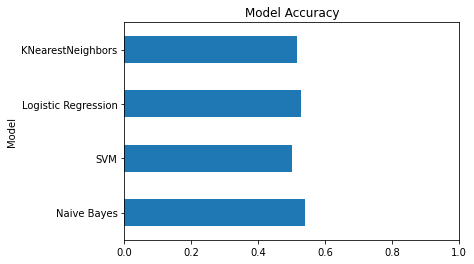

In [59]:
test_results.plot(kind='barh', y='Accuracy', title='Model Accuracy', ylabel='Model', legend=False, xlim=[0, 1])

<AxesSubplot:title={'center':'Model F1 Score'}, ylabel='Model'>

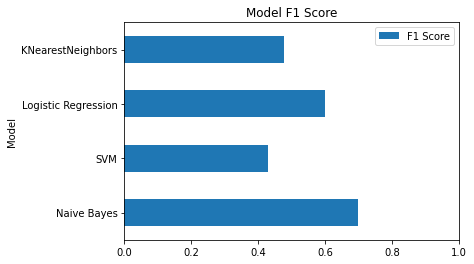

In [60]:
test_results.plot(kind='barh', y='F1 Score', title='Model F1 Score', xlabel='Model', xlim=[0,1])

## Competition Predictions

In [61]:
id_pipe.fit(x.Pitched_Business_Identifier)
desc_pipe.fit(x.Pitched_Business_Desc)
training_features = feature_transform(id_pipe, desc_pipe, x)

In [62]:
naive_model.fit(training_features, y_labels)

MultinomialNB()

In [63]:
np.mean(y_labels == naive_model.predict(feature_transform(id_pipe, desc_pipe, x)))

0.720754716981132

In [64]:
# Load in test set
test_set = pd.read_csv(os.path.join('data', 'intermediate_testset.csv'))
test_set

test_set['Pitched_Business_Identifier'] = (
    test_set.Pitched_Business_Identifier
        .str.lower()
        .str.replace(r"['-.\"]", '', regex=True)
        .str.replace(r'&', 'and', regex=True)
)

test_set['Pitched_Business_Desc'] = (
    test_set['Pitched_Business_Desc']
        .str.lower()
        .str.replace(r"['-.\"]", '', regex=True)
        .str.replace(r'&', 'and', regex=True)
        .str.replace(r'\s+a\s+', ' ', regex=True)
        .str.replace(r'\s+an\s+', ' ', regex=True)
        .str.replace(r'^a\s', '', regex=True)
        .str.replace(r'^an\s', '', regex=True)
)

# Create new feature for detailedness
test_set['detailedness'] = (
    test_set.Pitched_Business_Desc.apply(lambda x: len(x.split())) *
    test_set.Pitched_Business_Identifier.apply(lambda x: len(x.split()))
)


In [65]:
predictions = naive_model.predict(feature_transform(id_pipe, desc_pipe, test_set))

In [66]:
# Put predictions into csv
prediction_set = pd.DataFrame(data=predictions, columns=['Deal_Status'])
prediction_set

,Deal_Status
0,1
1,1
2,1
3,1
4,1
...,...
171,1
172,1
173,1
174,1


In [71]:
np.mean(predictions)

0.9829545454545454

In [72]:
np.sum(predictions)

173

In [67]:
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
      dtype=int64)

In [68]:
# Export dataset
with open(os.path.join('data', 'predictions.csv'), 'w', encoding='utf-8', newline='') as output:
    output.write(prediction_set.to_csv(index=False, mode='a'))

In [69]:
pd.read_csv(os.path.join('data', 'predictions.csv'))

,Deal_Status
0,1
1,1
2,1
3,1
4,1
...,...
171,1
172,1
173,1
174,1
